第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ．

# 70. 単語ベクトルの和による特徴量
問題50で構築した学習データ，検証データ，評価データを行列・ベクトルに変換したい．例えば，学習データについて，すべての事例xiの特徴ベクトルxiを並べた行列Xと，正解ラベルを並べた行列（ベクトル）Yを作成したい．

X=⎛⎝⎜⎜⎜⎜x1x2…xn⎞⎠⎟⎟⎟⎟∈ℝn×d,Y=⎛⎝⎜⎜⎜⎜y1y2…yn⎞⎠⎟⎟⎟⎟∈ℕn
ここで，nは学習データの事例数であり，xi∈ℝdとyi∈ℕはそれぞれ，i∈{1,…,n}番目の事例の特徴量ベクトルと正解ラベルを表す． なお，今回は「ビジネス」「科学技術」「エンターテイメント」「健康」の4カテゴリ分類である．ℕ<4で4未満の自然数（0を含む）を表すことにすれば，任意の事例の正解ラベルyiはyi∈ℕ<4で表現できる． 以降では，ラベルの種類数をLで表す（今回の分類タスクではL=4である）．

i番目の事例の特徴ベクトルxiは，次式で求める．

xi=1Ti∑t=1Tiemb(wi,t)
ここで，i番目の事例はTi個の（記事見出しの）単語列(wi,1,wi,2,…,wi,Ti)から構成され，emb(w)∈ℝdは単語wに対応する単語ベクトル（次元数はd）である．すなわち，i番目の事例の記事見出しを，その見出しに含まれる単語のベクトルの平均で表現したものがxiである．今回は単語ベクトルとして，問題60でダウンロードしたものを用いればよい．300次元の単語ベクトルを用いたので，d=300である．

i番目の事例のラベルyiは，次のように定義する．

yi=⎧⎩⎨⎪⎪0123(記事xiが「ビジネス」カテゴリの場合)(記事xiが「科学技術」カテゴリの場合)(記事xiが「エンターテイメント」カテゴリの場合)(記事xiが「健康」カテゴリの場合)
なお，カテゴリ名とラベルの番号が一対一で対応付いていれば，上式の通りの対応付けでなくてもよい．

以上の仕様に基づき，以下の行列・ベクトルを作成し，ファイルに保存せよ．

学習データの特徴量行列: Xtrain∈ℝNt×d
学習データのラベルベクトル: Ytrain∈ℕNt
検証データの特徴量行列: Xvalid∈ℝNv×d
検証データのラベルベクトル: Yvalid∈ℕNv
評価データの特徴量行列: Xtest∈ℝNe×d
評価データのラベルベクトル: Ytest∈ℕNe
なお，Nt,Nv,Neはそれぞれ，学習データの事例数，検証データの事例数，評価データの事例数である．



In [1]:
from gensim.models import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('../chap07/input/GoogleNews-vectors-negative300.bin', binary=True)

In [2]:
import numpy as np
import pandas as pd
import texthero as hero
import re
from swem import SWEM
# b = business, t = science and technology, e = entertainment, m = health
category_map = {"b": 0, "t": 1, "e": 2, "m": 3}
swem = SWEM(word_vectors)


In [54]:
dir_path = "../chap06/output/"
files = ["train", "valid", "test"]
for file in files:
    path = dir_path + file + ".txt"
    df = pd.read_table(path, header=None, names=("category", "title"))
    df["category"] = df["category"].map(category_map)
    df["title"] = hero.clean(df["title"], pipeline=[
        hero.preprocessing.fillna,
        hero.preprocessing.lowercase,
        hero.preprocessing.remove_digits,
        hero.preprocessing.remove_punctuation,
        hero.preprocessing.remove_diacritics,
        hero.preprocessing.remove_stopwords
    ])
    df["title"] = [swem.infer_vector(tokens=title, method="avg") for title in df["title"]]
    X = np.array([X for X in df["title"]])
    y = np.array(df["category"], dtype=np.int64)
    print(X.shape, y.shape)
    path_to = "./output/" + file
    np.savetxt(path_to + "_X", X)
    np.savetxt(path_to + "_y", y, fmt="%d")


(10672, 300) (10672,)
(1334, 300) (1334,)
(1334, 300) (1334,)


# 71. 単層ニューラルネットワークによる予測
問題70で保存した行列を読み込み，学習データについて以下の計算を実行せよ．

ŷ 1=softmax(x1W),Ŷ =softmax(X[1:4]W)
ただし，softmaxはソフトマックス関数，X[1:4]∈ℝ4×dは特徴ベクトルx1,x2,x3,x4を縦に並べた行列である．

X[1:4]=⎛⎝⎜⎜⎜⎜x1x2x3x4⎞⎠⎟⎟⎟⎟
行列W∈ℝd×Lは単層ニューラルネットワークの重み行列で，ここではランダムな値で初期化すればよい（問題73以降で学習して求める）．なお，ŷ 1∈ℝLは未学習の行列Wで事例x1を分類したときに，各カテゴリに属する確率を表すベクトルである． 同様に，Ŷ ∈ℝn×Lは，学習データの事例x1,x2,x3,x4について，各カテゴリに属する確率を行列として表現している．



In [3]:
X = np.loadtxt("./output/train_X")
y = np.loadtxt("./output/train_y", dtype=np.int64)
np.random.seed(seed=0)
W = np.random.rand(300, 4)

In [74]:
from scipy.special import softmax
y_1 = softmax(np.matmul(X[0], W))
Y = softmax(np.matmul(X[:4], W), axis=1)
print(y_1)
print(Y)

[0.29065256 0.20196849 0.28568237 0.22169657]
[[0.29065256 0.20196849 0.28568237 0.22169657]
 [0.2799393  0.19786299 0.28166245 0.24053525]
 [0.25940632 0.19147765 0.29258893 0.25652709]
 [0.25143516 0.2071726  0.30296661 0.23842563]]


## pytorchを使った実装

In [4]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(300, 4),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits

model = SimpleNet().to("cpu")
print(model)

SimpleNet(
  (linear_stack): Sequential(
    (0): Linear(in_features=300, out_features=4, bias=True)
    (1): Softmax(dim=1)
  )
)


In [151]:
#x = torch.from_numpy(X[0]).float()
X_4 = torch.from_numpy(X[:4]).float()
#print(model(x))
print(model(X_4))

tensor([[0.2600, 0.2413, 0.2407, 0.2581],
        [0.2561, 0.2392, 0.2432, 0.2616],
        [0.2584, 0.2415, 0.2418, 0.2584],
        [0.2575, 0.2386, 0.2422, 0.2618]], grad_fn=<SoftmaxBackward>)


# 72. 損失と勾配の計算
学習データの事例x1と事例集合x1,x2,x3,x4に対して，クロスエントロピー損失と，行列Wに対する勾配を計算せよ．なお，ある事例xiに対して損失は次式で計算される．

li=−log[事例xiがyiに分類される確率]
ただし，事例集合に対するクロスエントロピー損失は，その集合に含まれる各事例の損失の平均とする．



In [136]:
import math
def closs_entropy_loss(y_pred, y_true):
    return -math.log(y_pred[y_true])

loss = closs_entropy_loss(y_1, y[0])
print("loss for x1:", loss)
loss_1to4 = sum([closs_entropy_loss(y_pred, y[i]) for i, y_pred in enumerate(Y)])
print("loss for x1~x4:", loss_1to4)

loss for x1: 1.235626663422327
loss for x1~x4: 4.925791861011294


In [5]:
# pytorchを用いた実装
loss = nn.CrossEntropyLoss(reduction="sum")
X_4 = torch.from_numpy(X[:4]).float()
y_true_4 = torch.from_numpy(y[:4]).long()
output = loss(model(X_4), y_true_4)
print("loss:", output)

loss: tensor(5.5509, grad_fn=<NllLossBackward>)


# 73. 確率的勾配降下法による学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列Wを学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．



In [8]:
train_X = torch.from_numpy(np.loadtxt("./output/train_X")).float()
train_y = torch.from_numpy(np.loadtxt("./output/train_y")).long()
train_dataset = torch.utils.data.TensorDataset(train_X, train_y)
train_dataloader = torch.utils.data.DataLoader(train_dataset)

In [9]:
test_X = torch.from_numpy(np.loadtxt("./output/test_X")).float()
test_y = torch.from_numpy(np.loadtxt("./output/test_y")).long()
test_dataset = torch.utils.data.TensorDataset(test_X, test_y)
test_dataloader = torch.utils.data.DataLoader(test_dataset)

In [10]:
learning_rate = 1e-3
#batch_size = 64
epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [157]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 1.376356  [    0/10672]
loss: 1.377466  [  100/10672]
loss: 1.373157  [  200/10672]
loss: 1.369860  [  300/10672]
loss: 1.387646  [  400/10672]
loss: 1.385123  [  500/10672]
loss: 1.398395  [  600/10672]
loss: 1.352973  [  700/10672]
loss: 1.404158  [  800/10672]
loss: 1.374236  [  900/10672]
loss: 1.409981  [ 1000/10672]
loss: 1.377031  [ 1100/10672]
loss: 1.372840  [ 1200/10672]
loss: 1.337023  [ 1300/10672]
loss: 1.371597  [ 1400/10672]
loss: 1.332374  [ 1500/10672]
loss: 1.365273  [ 1600/10672]
loss: 1.323455  [ 1700/10672]
loss: 1.357345  [ 1800/10672]
loss: 1.359729  [ 1900/10672]
loss: 1.359824  [ 2000/10672]
loss: 1.352996  [ 2100/10672]
loss: 1.350341  [ 2200/10672]
loss: 1.346632  [ 2300/10672]
loss: 1.317494  [ 2400/10672]
loss: 1.312751  [ 2500/10672]
loss: 1.315899  [ 2600/10672]
loss: 1.451793  [ 2700/10672]
loss: 1.306592  [ 2800/10672]
loss: 1.449003  [ 2900/10672]
loss: 1.456150  [ 3000/10672]
loss: 1.332735  [ 3100/10672]


In [158]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


# 74. 正解率の計測
問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．



In [11]:
model = SimpleNet()
model.load_state_dict(torch.load("model.pth"))
loss_fn = nn.CrossEntropyLoss()
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [12]:
print("<train>")
test_loop(train_dataloader, model, loss_fn)
print("<test>")
test_loop(test_dataloader, model, loss_fn)

<train>
Test Error: 
 Accuracy: 55.1%, Avg loss: 1.220320 

<test>
Test Error: 
 Accuracy: 53.4%, Avg loss: 1.226426 



# 75. 損失と正解率のプロット
問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．



# 76. チェックポイント
問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．

In [13]:
import matplotlib.pyplot as plt
learning_rate = 1e-3
#batch_size = 64
epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    return test_loss, correct

Epoch 1
-------------------------------
loss: 1.216791142459618, accuracy: 0.5513493253373314

Epoch 2
-------------------------------
loss: 1.2165833510726556, accuracy: 0.5514430284857571

Epoch 3
-------------------------------
loss: 1.2163750674335405, accuracy: 0.5512556221889056

Epoch 4
-------------------------------
loss: 1.2161682940617404, accuracy: 0.5512556221889056

Epoch 5
-------------------------------
loss: 1.2159631994107496, accuracy: 0.5513493253373314

Epoch 6
-------------------------------
loss: 1.215759788764113, accuracy: 0.5511619190404797

Epoch 7
-------------------------------
loss: 1.2155580220931117, accuracy: 0.5512556221889056

Epoch 8
-------------------------------
loss: 1.215357843747382, accuracy: 0.5515367316341829

Epoch 9
-------------------------------
loss: 1.215159274006578, accuracy: 0.5518178410794603

Epoch 10
-------------------------------
loss: 1.2149622939482354, accuracy: 0.5518178410794603

Epoch 11
-------------------------------
lo

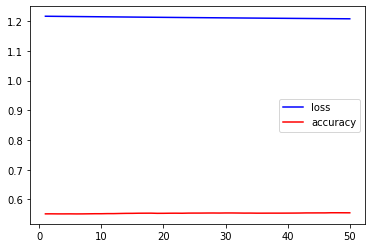

In [19]:
epochs = 50
x = [i for i in range(1, epochs+1)]
losses = []
acus = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    loss, accuracy = test_loop(train_dataloader, model, loss_fn)
    print(f"loss: {loss}, accuracy: {accuracy}\n")
    losses.append(loss)
    acus.append(accuracy)
    outfile = f"./checkpoint/out_{t:0=2}.cpt"
    torch.save(
        {'iter': t,
        'model_state_dict': model.state_dict(),
        'opt_state_dict': optimizer.state_dict(),
        'loss': losses,
        }, outfile
    )
plt.plot(x, losses, color="b", label="loss")
plt.plot(x, acus, color="r", label="accuracy")
plt.legend()
plt.show()
print("Done!")

# 77. ミニバッチ化
問題76のコードを改変し，B事例ごとに損失・勾配を計算し，行列Wの値を更新せよ（ミニバッチ化）．Bの値を1,2,4,8,…と変化させながら，1エポックの学習に要する時間を比較せよ．



In [38]:
import time
times = []
sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
for size in sizes:
    train_dataloader = DataLoader(train_dataset, batch_size=size)
    start = time.time()
    train_loop(train_dataloader, model, loss_fn, optimizer)
    elapsed_time = time.time() - start
    times.append(elapsed_time)

In [39]:
times

[3.5974998474121094,
 1.5193920135498047,
 0.7776110172271729,
 0.42693185806274414,
 0.2495279312133789,
 0.15306806564331055,
 0.10625100135803223,
 0.08716487884521484,
 0.07274293899536133,
 0.07892298698425293]

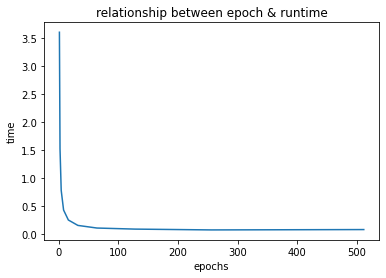

In [40]:
plt.plot(sizes, times)
plt.xlabel("epochs")
plt.ylabel("time")
plt.title("relationship between epoch & runtime")
plt.show()

# 78. GPU上での学習
問題77のコードを改変し，GPU上で学習を実行せよ．



# 79. 多層ニューラルネットワーク
問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．

google colabのGPUを利用した
- [code](https://colab.research.google.com/drive/10pzYcGvT5tNxa3WwQIwqX7FDov8kMzCx?usp=sharing)